In [1]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from causalgraphicalmodels import CausalGraphicalModel
from dowhy import CausalModel
import dowhy.datasets
from networkx.drawing.nx_pydot import write_dot
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite.gml import write_gml
import numpy as np
import math

In [2]:
def gen_estimate(gml_graph, input_df, treatment_col, outcome_col):
        # With graph
    model=CausalModel(
            data = input_df,
            treatment=treatment_col,
            outcome=outcome_col,
            graph=gml_graph
            )
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    causal_estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.linear_regression",target_units="ate")
    print(causal_estimate)
    return causal_estimate.value

In [3]:
def filter_skewed(treatment_cols, seasons, df):
    values = []
    for t in treatment_cols:
        print(t)
        tmp = []
        for s in seasons:
            print(s)
            one_season = df[df['season'] == s]
            treated = len(one_season[one_season[t] == 1])
            untreated = len(one_season[one_season[t] == 0])
            th_treated = treated/(treated + untreated)
            th_untreated = untreated/(treated + untreated)
            if (th_treated >= 0.3) and (th_untreated >= 0.3):
                tmp.append(1)
            else:
                tmp.append(None)
        print(tmp)
        values.append(tmp)
    return dict(zip(treatment_cols, values))

In [4]:
def get_df(treatment, df):
    df_return = df
    if treatment == 'Minutes':
        column = [0, 10, 20, 30, 40, math.inf]
        column_name = ['minutes<10', 'minutes10_20', 'minutes20_30', 'minutes30_40', 'minutes>=40']
        for i in range(len(column_name)):
            df_return[column_name[i]] = 0
            slice_indices = (df_return['Minutes'] >= column[i]) & (df_return['Points'] < column[i+1])
            df_return.loc[slice_indices, column_name[i]]=1
        return df_return, column_name
    
    if treatment == "Points":
        column = [0, 10, 20, 30, 40, math.inf]
        column_name = ['points<10', 'points10_20', 'points20_30', 'points30_40', 'points>=40']
        for i in range(len(column_name)):
            df_return[column_name[i]] = 0
            slice_indices = (df_return['Points'] >= column[i]) & (df_return['Points'] < column[i+1])
            df_return.loc[slice_indices, column_name[i]]=1
        return df_return, column_name
    
    if treatment == "Fouls":
        column = [0,1,2,3,4,5,6]
        column_name = ['fouls=0', 'fouls=1', 'fouls=2', 'fouls=3', 'fouls=4', 'fouls=5', 'fouls=6']
        for i in range(len(column_name)):
            df_return[column_name[i]] = 0
            slice_indices = (df_return['Fouls'] == column[i])
            df_return.loc[slice_indices, column_name[i]]=1
        return df_return, column_name
    
    if treatment == 'Assists':
        column = [0,3,6,9,12,math.inf]
        column_name = ['assists<3', 'assists3_6', 'assists6_9','assists9_12', 'assists>=12']
        for i in range(len(column_name)):
            df_return[column_name[i]] = 0
            slice_indices = (df_return['Assists'] >= column[i]) & (df_return['Assists'] < column[i+1]) 
            df_return.loc[slice_indices, column_name[i]]=1
        return df_return, column_name
    
    if treatment == 'Rebounds':
        column = [0,3,6,9,12,15,math.inf]
        column_name = ['rebounds<3', 'rebounds3_6', 'rebounds6_9','rebounds9_12','rebounds12_15', 'rebounds>=15']
        for i in range(len(column_name)):
            df_return[column_name[i]] = 0
            slice_indices = (df_return['Rebounds'] >= column[i]) & (df_return['Rebounds'] < column[i+1]) 
            df_return.loc[slice_indices, column_name[i]]=1
        return df_return, column_name
            
    if treatment == 'Turnovers':
        column = [0,3,6,9,12,math.inf]
        column_name = ['turnovers<3', 'turnovers3_6', 'turnovers6_9','turnovers9_12', 'turnovers>=12']
        for i in range(len(column_name)):
            df_return[column_name[i]] = 0
            slice_indices = (df_return['Turnovers'] >= column[i]) & (df_return['Turnovers'] < column[i+1]) 
            df_return.loc[slice_indices, column_name[i]]=1
        return df_return, column_name
            
    if treatment == 'Fg2Pct':
        column = [0,0.25, 0.5, 0.75, 1.0001]
        column_name = ['Fg2Pct<0.25', 'Fg2Pct_0.25_0.5', 'Fg2Pct_0.5_0.75','Fg2Pct_0.75_1']
        for i in range(len(column_name)):
            df_return[column_name[i]] = 0
            slice_indices = (df_return['Fg2Pct'] >= column[i]) & (df_return['Fg2Pct'] < column[i+1]) 
            df_return.loc[slice_indices, column_name[i]]=1
        return df_return, column_name
    
    if treatment == 'Fg3Pct':
        column = [0,0.25, 0.5, 0.75, 1.0001]
        column_name = ['Fg3Pct<0.25', 'Fg3Pct_0.25_0.5', 'Fg3Pct_0.5_0.75','Fg3Pct_0.75_1']
        for i in range(len(column_name)):
            df_return[column_name[i]] = 0
            slice_indices = (df_return['Fg3Pct'] >= column[i]) & (df_return['Fg3Pct'] < column[i+1]) 
            df_return.loc[slice_indices, column_name[i]]=1
        return df_return, column_name

In [5]:
def graph(treatment, treatmemt_i, outcome):
    lst = [
            ("Minutes", "Assists"), 
            ("Minutes", "Rebounds"), 
            ("Minutes", "Points"), 
            ("Fg3Pct", "Points"),
            ("Fg2Pct", "Points"), 
            ("Points", outcome),
            ("Assists", outcome),
            ("Rebounds", outcome),
            ("Turnovers", outcome),
            ("Fouls", outcome),
            ("is_home", outcome),
    ]
    
    for i in range(len(lst)):
        lst[i] = list(lst[i])
        if lst[i][0] == treatment:
            lst[i][0] = treatmemt_i
        if lst[i][1] == treatment:
            lst[i][1] = treatmemt_i
        lst[i] = tuple(lst[i])

    G = nx.DiGraph()
    G.add_edges_from(lst)
    write_gml(G, 'testgml')
    with open('testgml') as f: s = f.read()
    return s

In [6]:
def get_est(player_name, treatment, outcome, season_type):
    loc = '/Users/sdy/Desktop/Casual Inference/' + str(player_name) + '.csv'
    df = pd.read_csv(loc)
    df = df.fillna(0)
    df = df.drop(['Unnamed: 0'],axis=1)
    df = df.drop(["Date","HomePoints",
                         "AwayPoints", "HomeTeamAbbreviation","AwayTeamAbbreviation", 
                         "FtPoints", "FG2A", "FG3A"],axis=1)
    
    seasons = df['season'].unique()
    
    if season_type == 'Regular Season':
        df_regular = df[df['season_type'] == 'Regular Season']
        df, treatment_cols = get_df(treatment, df_regular)
        th = filter_skewed(treatment_cols, seasons, df)
        df = df.groupby('season')
    
    if season_type == 'Playoffs':
        df_playoff = df[df['season_type'] == 'Playoffs']
        df, treatment_cols = get_df(treatment, df_playoff)
        th = filter_skewed(treatment_cols, seasons, df)
        df = df.groupby('season')


    estimates  = []
    
    for t in treatment_cols:
        th_i = th.get(t)
        i = 0
        for season, split_df in df:
            if th_i[i] == None:
                estimates.append({'treatment':t, 'outcome':outcome, 'season':season,'ate':None})
            else:
                try:
                    est = gen_estimate(graph(treatment, t, outcome),split_df,t,outcome)
                    estimates.append({'treatment':t, 'outcome':outcome, 'season':season,'ate':est})
                except:
                    estimates.append({'treatment':t, 'season':season, 'estimate':None})
            i = i+1
    estimates_df=pd.DataFrame(estimates)
    
    return estimates_df 

# Causal Graph

In [7]:
loc = '/Users/sdy/Desktop/Casual Inference/herro.csv'
df = pd.read_csv(loc)
df = df.fillna(0)
df = df.drop(['Unnamed: 0'],axis=1)
df = df.drop(["Date","HomePoints",
                     "AwayPoints", "HomeTeamAbbreviation","AwayTeamAbbreviation", 
                     "FtPoints", "FG2A", "FG3A"],axis=1)

In [8]:
a = df['Fouls'].unique()
a[0] == 2

True

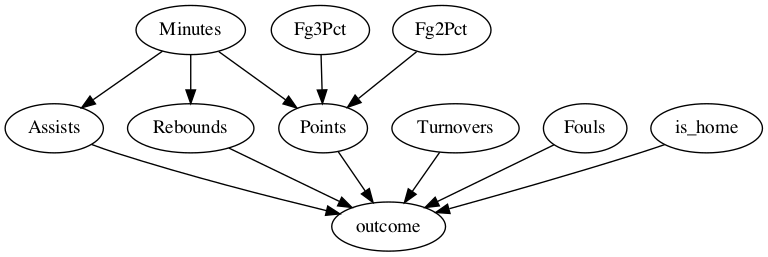

In [9]:
outcome = 'outcome'
lst = [
        ("Minutes", "Assists"), 
        ("Minutes", "Rebounds"), 
        ("Minutes", "Points"), 
        ("Fg3Pct", "Points"),
        ("Fg2Pct", "Points"), 
        ("Points", outcome),
        ("Assists", outcome),
        ("Rebounds", outcome),
        ("Turnovers", outcome),
        ("Fouls", outcome),
        ("is_home", outcome),
]

G = nx.DiGraph()
G.add_edges_from(lst)
write_gml(G, 'testgml')
with open('testgml') as f: s = f.read()
    
import pygraphviz

model= dowhy.CausalModel(
        data = df,
        graph=s,
        treatment= 'Minutes',
        outcome= 'mia_points')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

# Herro

## outcome = mia_points

In [11]:
estimate_df_minutes_mia_points = get_est('herro', 'Minutes', 'mia_points', 'Regular Season')

estimate_df_assists_mia_points = get_est('herro', 'Assists', 'mia_points', 'Regular Season')

estimate_df_rebounds_mia_points = get_est('herro', 'Rebounds', 'mia_points', 'Regular Season')

estimate_df_points_mia_points = get_est('herro', 'Points', 'mia_points', 'Regular Season')

estimate_df_turnovers_mia_points = get_est('herro', 'Turnovers', 'mia_points', 'Regular Season')

estimate_df_fouls_mia_points = get_est('herro', 'Fouls', 'mia_points', 'Regular Season')

estimate_df_fg3_mia_points = get_est('herro', 'Fg3Pct', 'mia_points', 'Regular Season')

estimate_df_fg2_mia_points = get_est('herro', 'Fg2Pct', 'mia_points', 'Regular Season')

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

minutes<10
2019-20
2020-21
2021-22
[1, None, None]
minutes10_20
2019-20
2020-21
2021-22
[None, None, 1]
minutes20_30
2019-20
2020-21
2021-22
[None, None, None]
minutes30_40
2019-20
2020-21
2021-22
[1, 1, None]
minutes>=40
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                    
─────────────(E[miaₚₒᵢₙₜₛ])
d[minutes<10]              
Estimand assumption 1, Unconfoundedness: If U→{minutes<10} and U→mia_points then P(mia_points|minutes<10,,U) = P(mia_points|minutes<10,)

## Realized estimand
b: mia_points~minutes<10+minutes<10*Turnovers+minutes<10*Fg3Pct+minutes<10*Fg2Pct+minutes<10*is_home+minutes<10*Fouls
Target units: ate

## Estimate
Mean value: 0.9734834936690646

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expressio

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Fg3Pct<0.25
2019-20
2020-21
2021-22
[None, 1, None]
Fg3Pct_0.25_0.5
2019-20
2020-21
2021-22
[1, 1, None]
Fg3Pct_0.5_0.75
2019-20
2020-21
2021-22
[None, None, 1]
Fg3Pct_0.75_1
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                     
──────────────(E[miaₚₒᵢₙₜₛ])
d[Fg3Pct<0.25]              
Estimand assumption 1, Unconfoundedness: If U→{Fg3Pct<0.25} and U→mia_points then P(mia_points|Fg3Pct<0.25,,U) = P(mia_points|Fg3Pct<0.25,)

## Realized estimand
b: mia_points~Fg3Pct<0.25+Fg3Pct<0.25*Turnovers+Fg3Pct<0.25*Rebounds+Fg3Pct<0.25*Minutes+Fg3Pct<0.25*Assists+Fg3Pct<0.25*Fouls+Fg3Pct<0.25*Fg2Pct+Fg3Pct<0.25*is_home
Target units: ate

## Estimate
Mean value: 0.24659140247256062

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand e

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [12]:
estimate_mia_points = pd.concat([estimate_df_minutes_mia_points, estimate_df_assists_mia_points, estimate_df_rebounds_mia_points, 
                 estimate_df_points_mia_points, estimate_df_turnovers_mia_points, estimate_df_fouls_mia_points, 
                 estimate_df_fg3_mia_points, estimate_df_fg2_mia_points], ignore_index=True)


In [13]:
estimate_mia_points = estimate_mia_points.sort_values(by=['ate'], ascending=False).head(20)
estimate_mia_points.style.set_caption("Player Herro")

,treatment,outcome,season,ate
107,Fg3Pct_0.5_0.75,mia_points,2021-22,7.017719
9,minutes30_40,mia_points,2019-20,6.662140
20,assists3_6,mia_points,2021-22,5.825654
38,rebounds6_9,mia_points,2021-22,5.182192
51,points10_20,mia_points,2019-20,4.150132
119,Fg2Pct_0.5_0.75,mia_points,2021-22,3.892101
56,points20_30,mia_points,2021-22,3.620878
10,minutes30_40,mia_points,2020-21,3.491423
15,assists<3,mia_points,2019-20,2.414252
19,assists3_6,mia_points,2020-21,2.021127


## outcome is win/lose

In [14]:
estimate_df_minutes_outcome = get_est('herro', 'Minutes', 'outcome', 'Regular Season')

estimate_df_assists_outcome = get_est('herro', 'Assists', 'outcome', 'Regular Season')

estimate_df_rebounds_outcome = get_est('herro', 'Rebounds', 'outcome', 'Regular Season')

estimate_df_points_outcome = get_est('herro', 'Points', 'outcome', 'Regular Season')

estimate_df_turnovers_outcome = get_est('herro', 'Turnovers', 'outcome', 'Regular Season')

estimate_df_fouls_mia_outcome= get_est('herro', 'Fouls', 'outcome', 'Regular Season')

estimate_df_fg3_mia_outcome = get_est('herro', 'Fg3Pct', 'outcome', 'Regular Season')

estimate_df_fg2_mia_outcome = get_est('herro', 'Fg2Pct', 'outcome', 'Regular Season')

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

minutes<10
2019-20
2020-21
2021-22
[1, None, None]
minutes10_20
2019-20
2020-21
2021-22
[None, None, 1]
minutes20_30
2019-20
2020-21
2021-22
[None, None, None]
minutes30_40
2019-20
2020-21
2021-22
[1, 1, None]
minutes>=40
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
─────────────(E[outcome])
d[minutes<10]            
Estimand assumption 1, Unconfoundedness: If U→{minutes<10} and U→outcome then P(outcome|minutes<10,,U) = P(outcome|minutes<10,)

## Realized estimand
b: outcome~minutes<10+minutes<10*Turnovers+minutes<10*Fg3Pct+minutes<10*Fg2Pct+minutes<10*is_home+minutes<10*Fouls
Target units: ate

## Estimate
Mean value: -0.14264200618466993

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d     

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

[1, 1, None]
Fg3Pct_0.5_0.75
2019-20
2020-21
2021-22
[None, None, 1]
Fg3Pct_0.75_1
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                   
──────────────(E[outcome])
d[Fg3Pct<0.25]            
Estimand assumption 1, Unconfoundedness: If U→{Fg3Pct<0.25} and U→outcome then P(outcome|Fg3Pct<0.25,,U) = P(outcome|Fg3Pct<0.25,)

## Realized estimand
b: outcome~Fg3Pct<0.25+Fg3Pct<0.25*Turnovers+Fg3Pct<0.25*Rebounds+Fg3Pct<0.25*Minutes+Fg3Pct<0.25*Assists+Fg3Pct<0.25*Fouls+Fg3Pct<0.25*Fg2Pct+Fg3Pct<0.25*is_home
Target units: ate

## Estimate
Mean value: -0.18690967508349204

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                     
──────────────────(E[outcome])
d[Fg3Pct_0.25_0.5]            
Estim

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [15]:
estimate_win_lose = pd.concat([estimate_df_minutes_outcome, estimate_df_assists_outcome, estimate_df_rebounds_outcome,
                              estimate_df_points_outcome, estimate_df_turnovers_outcome, estimate_df_fouls_mia_outcome, 
                              estimate_df_fg3_mia_outcome, estimate_df_fg2_mia_outcome], ignore_index=True)


In [17]:
estimate_win_lose = estimate_win_lose.sort_values(by=['ate'], ascending=False).head(20)
estimate_win_lose.style.set_caption("Player Herro")

,treatment,outcome,season,ate
51,points10_20,outcome,2019-20,0.369518
119,Fg2Pct_0.5_0.75,outcome,2021-22,0.202102
56,points20_30,outcome,2021-22,0.185034
38,rebounds6_9,outcome,2021-22,0.174083
19,assists3_6,outcome,2020-21,0.168583
107,Fg3Pct_0.5_0.75,outcome,2021-22,0.123591
64,turnovers<3,outcome,2020-21,0.082831
65,turnovers<3,outcome,2021-22,0.076077
15,assists<3,outcome,2019-20,0.064261
114,Fg2Pct_0.25_0.5,outcome,2019-20,0.047546


# Jimmy Butler

## outcome_mia_points

In [18]:
estimate_df_minutes_mia_points = get_est('jimmy', 'Minutes', 'mia_points', 'Regular Season')

estimate_df_assists_mia_points = get_est('jimmy', 'Assists', 'mia_points', 'Regular Season')

estimate_df_rebounds_mia_points = get_est('jimmy', 'Rebounds', 'mia_points', 'Regular Season')

estimate_df_points_mia_points = get_est('jimmy', 'Points', 'mia_points', 'Regular Season')

estimate_df_turnovers_mia_points = get_est('jimmy', 'Turnovers', 'mia_points', 'Regular Season')

estimate_df_fouls_mia_points = get_est('jimmy', 'Fouls', 'mia_points', 'Regular Season')

estimate_df_fg3_mia_points = get_est('jimmy', 'Fg3Pct', 'mia_points', 'Regular Season')

estimate_df_fg2_mia_points = get_est('jimmy', 'Fg2Pct', 'mia_points', 'Regular Season')

estimate_mia_points = pd.concat([estimate_df_minutes_mia_points, estimate_df_assists_mia_points, estimate_df_rebounds_mia_points, 
                 estimate_df_points_mia_points, estimate_df_turnovers_mia_points, estimate_df_fouls_mia_points, 
                 estimate_df_fg3_mia_points, estimate_df_fg2_mia_points], ignore_index=True)

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

minutes<10
2019-20
2020-21
2021-22
[None, None, None]
minutes10_20
2019-20
2020-21
2021-22
[1, 1, 1]
minutes20_30
2019-20
2020-21
2021-22
[None, None, None]
minutes30_40
2019-20
2020-21
2021-22
[None, None, None]
minutes>=40
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                     
───────────────(E[miaₚₒᵢₙₜₛ])
d[minutes₁₀ ₂₀]              
Estimand assumption 1, Unconfoundedness: If U→{minutes10_20} and U→mia_points then P(mia_points|minutes10_20,,U) = P(mia_points|minutes10_20,)

## Realized estimand
b: mia_points~minutes10_20+minutes10_20*Turnovers+minutes10_20*Fg3Pct+minutes10_20*Fg2Pct+minutes10_20*is_home+minutes10_20*Fouls
Target units: ate

## Estimate
Mean value: -0.8420368362672974

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name:

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                   
──────────(E[miaₚₒᵢₙₜₛ])
d[fouls=1]              
Estimand assumption 1, Unconfoundedness: If U→{fouls=1} and U→mia_points then P(mia_points|fouls=1,,U) = P(mia_points|fouls=1,)

## Realized estimand
b: mia_points~fouls=1+fouls=1*Turnovers+fouls=1*Rebounds+fouls=1*Fg3Pct+fouls=1*Minutes+fouls=1*Points+fouls=1*Assists+fouls=1*Fg2Pct+fouls=1*is_home
Target units: ate

## Estimate
Mean value: 0.6382049726816348

Fg3Pct<0.25
2019-20
2020-21
2021-22
[None, 1, None]
Fg3Pct_0.25_0.5
2019-20
2020-21
2021-22
[None, None, None]
Fg3Pct_0.5_0.75
2019-20
2020-21
2021-22
[None, None, None]
Fg3Pct_0.75_1
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d              

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [19]:
estimate_mia_points = estimate_mia_points.sort_values(by=['ate'], ascending=False).head(20)
estimate_mia_points.style.set_caption("Player Jimmy")

,treatment,outcome,season,ate
118,Fg2Pct_0.5_0.75,mia_points,2020-21,9.009841
119,Fg2Pct_0.5_0.75,mia_points,2021-22,8.238774
56,points20_30,mia_points,2021-22,7.378703
63,turnovers<3,mia_points,2019-20,3.703355
54,points20_30,mia_points,2019-20,3.136195
68,turnovers3_6,mia_points,2021-22,3.037282
33,rebounds3_6,mia_points,2019-20,2.656987
38,rebounds6_9,mia_points,2021-22,2.546901
35,rebounds3_6,mia_points,2021-22,2.108979
4,minutes10_20,mia_points,2020-21,1.907880


## outcome_win_lose

In [20]:
estimate_df_minutes_outcome = get_est('jimmy', 'Minutes', 'outcome', 'Regular Season')

estimate_df_assists_outcome = get_est('jimmy', 'Assists', 'outcome', 'Regular Season')

estimate_df_rebounds_outcome = get_est('jimmy', 'Rebounds', 'outcome', 'Regular Season')

estimate_df_points_outcome = get_est('jimmy', 'Points', 'outcome', 'Regular Season')

estimate_df_turnovers_outcome = get_est('jimmy', 'Turnovers', 'outcome', 'Regular Season')

estimate_df_fouls_mia_outcome= get_est('jimmy', 'Fouls', 'outcome', 'Regular Season')

estimate_df_fg3_mia_outcome = get_est('jimmy', 'Fg3Pct', 'outcome', 'Regular Season')

estimate_df_fg2_mia_outcome = get_est('jimmy', 'Fg2Pct', 'outcome', 'Regular Season')

estimate_win_lose = pd.concat([estimate_df_minutes_outcome, estimate_df_assists_outcome, estimate_df_rebounds_outcome,
                              estimate_df_points_outcome, estimate_df_turnovers_outcome, estimate_df_fouls_mia_outcome, 
                              estimate_df_fg3_mia_outcome, estimate_df_fg2_mia_outcome], ignore_index=True)


/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

minutes<10
2019-20
2020-21
2021-22
[None, None, None]
minutes10_20
2019-20
2020-21
2021-22
[1, 1, 1]
minutes20_30
2019-20
2020-21
2021-22
[None, None, None]
minutes30_40
2019-20
2020-21
2021-22
[None, None, None]
minutes>=40
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                   
───────────────(E[outcome])
d[minutes₁₀ ₂₀]            
Estimand assumption 1, Unconfoundedness: If U→{minutes10_20} and U→outcome then P(outcome|minutes10_20,,U) = P(outcome|minutes10_20,)

## Realized estimand
b: outcome~minutes10_20+minutes10_20*Turnovers+minutes10_20*Fg3Pct+minutes10_20*Fg2Pct+minutes10_20*is_home+minutes10_20*Fouls
Target units: ate

## Estimate
Mean value: 0.09109000139059498

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                 
──────────(E[outcome])
d[fouls=1]            
Estimand assumption 1, Unconfoundedness: If U→{fouls=1} and U→outcome then P(outcome|fouls=1,,U) = P(outcome|fouls=1,)

## Realized estimand
b: outcome~fouls=1+fouls=1*Turnovers+fouls=1*Rebounds+fouls=1*Fg3Pct+fouls=1*Minutes+fouls=1*Points+fouls=1*Assists+fouls=1*Fg2Pct+fouls=1*is_home
Target units: ate

## Estimate
Mean value: 0.12721034319167313

Fg3Pct<0.25
2019-20
2020-21
2021-22
[None, 1, None]
Fg3Pct_0.25_0.5
2019-20
2020-21
2021-22
[None, None, None]
Fg3Pct_0.5_0.75
2019-20
2020-21
2021-22
[None, None, None]
Fg3Pct_0.75_1
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                   
───────────

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_71447/2091572772.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [21]:
estimate_win_lose = estimate_win_lose.sort_values(by=['ate'], ascending=False).head(20)
estimate_win_lose.style.set_caption("Player Jimmy")

,treatment,outcome,season,ate
55,points20_30,outcome,2020-21,0.452230
68,turnovers3_6,outcome,2021-22,0.333372
25,assists9_12,outcome,2020-21,0.317964
37,rebounds6_9,outcome,2020-21,0.146099
56,points20_30,outcome,2021-22,0.144494
82,fouls=1,outcome,2020-21,0.127210
67,turnovers3_6,outcome,2020-21,0.093887
3,minutes10_20,outcome,2019-20,0.091090
119,Fg2Pct_0.5_0.75,outcome,2021-22,0.065842
63,turnovers<3,outcome,2019-20,0.042381


# Curry

## outcome_gsw_points

In [22]:
estimate_df_minutes_gsw_points = get_est('curry', 'Minutes', 'gsw_points', 'Regular Season')

estimate_df_assists_gsw_points = get_est('curry', 'Assists', 'gsw_points', 'Regular Season')

estimate_df_rebounds_gsw_points = get_est('curry', 'Rebounds', 'gsw_points', 'Regular Season')

estimate_df_points_gsw_points = get_est('curry', 'Points', 'gsw_points', 'Regular Season')

estimate_df_turnovers_gsw_points = get_est('curry', 'Turnovers', 'gsw_points', 'Regular Season')

estimate_df_fouls_gsw_points = get_est('curry', 'Fouls', 'gsw_points', 'Regular Season')

estimate_df_fg3_gsw_points = get_est('curry', 'Fg3Pct', 'gsw_points', 'Regular Season')

estimate_df_fg2_gsw_points = get_est('curry', 'Fg2Pct', 'gsw_points', 'Regular Season')

estimate_gsw_points = pd.concat([estimate_df_minutes_gsw_points, estimate_df_assists_gsw_points, estimate_df_rebounds_gsw_points, 
                 estimate_df_points_gsw_points, estimate_df_turnovers_gsw_points, estimate_df_fouls_gsw_points, 
                 estimate_df_fg3_gsw_points, estimate_df_fg2_gsw_points], ignore_index=True)


minutes<10
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
minutes10_20
2014-15
2016-17
2013-14
2012-13
2015-16
[1, None, 1, 1, None]
minutes20_30
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, 1]
minutes30_40
2014-15
2016-17
2013-14
2012-13
2015-16
[1, None, None, None, 1]
minutes>=40
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, 1, 1, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                     
───────────────(E[gswₚₒᵢₙₜₛ])
d[minutes₁₀ ₂₀]              
Estimand assumption 1, Unconfoundedness: If U→{minutes10_20} and U→gsw_points then P(gsw_points|minutes10_20,,U) = P(gsw_points|minutes10_20,)

## Realized estimand
b: gsw_points~minutes10_20+minutes10_20*Turnovers+minutes10_20*Fg3Pct+minutes10_20*Fg2Pct+minutes10_20*is_home+minutes10_20*Fouls
Target units: ate

## Estimate
Mean value: -3.3824648856143256

*

2015-16
[None, None, None, None, 1]
points>=40
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                              
──────────────(E[gsw_points|Minutes])
d[points₂₀ ₃₀]                       
Estimand assumption 1, Unconfoundedness: If U→{points20_30} and U→gsw_points then P(gsw_points|points20_30,Minutes,U) = P(gsw_points|points20_30,Minutes)

## Realized estimand
b: gsw_points~points20_30+Minutes+points20_30*Turnovers+points20_30*Rebounds+points20_30*is_home+points20_30*Assists+points20_30*Fouls
Target units: ate

## Estimate
Mean value: 0.051238808011262904

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                              
──────────────(E[gsw_points|Minutes])
d[

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                     
───────────────(E[gswₚₒᵢₙₜₛ])
d[turnovers₃ ₆]              
Estimand assumption 1, Unconfoundedness: If U→{turnovers3_6} and U→gsw_points then P(gsw_points|turnovers3_6,,U) = P(gsw_points|turnovers3_6,)

## Realized estimand
b: gsw_points~turnovers3_6+turnovers3_6*Fg3Pct+turnovers3_6*Rebounds+turnovers3_6*Minutes+turnovers3_6*Points+turnovers3_6*Assists+turnovers3_6*Fouls+turnovers3_6*Fg2Pct+turnovers3_6*is_home
Target units: ate

## Estimate
Mean value: -5.7053852530720945

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                     
───────────────(E[gswₚₒᵢₙₜₛ])
d[turnovers₃ ₆]              
Estimand assumption 1, Unconfoundedness: If U→{turnovers3_6} and U→gsw_points then P(g

Fg2Pct<0.25
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
Fg2Pct_0.25_0.5
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, 1, 1, None]
Fg2Pct_0.5_0.75
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, 1, 1, 1]
Fg2Pct_0.75_1
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                       
──────────────────(E[gswₚₒᵢₙₜₛ])
d[Fg2Pct_0.25_0.5]              
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct_0.25_0.5} and U→gsw_points then P(gsw_points|Fg2Pct_0.25_0.5,,U) = P(gsw_points|Fg2Pct_0.25_0.5,)

## Realized estimand
b: gsw_points~Fg2Pct_0.25_0.5+Fg2Pct_0.25_0.5*Turnovers+Fg2Pct_0.25_0.5*Rebounds+Fg2Pct_0.25_0.5*Fg3Pct+Fg2Pct_0.25_0.5*Minutes+Fg2Pct_0.25_0.5*Assists+Fg2Pct_0.25_0.5*Fouls+Fg2Pct_0.25_0.5*is_home
Target units: ate

## Estimate
Mean value: -3.78392037002

In [23]:
estimate_gsw_points = estimate_gsw_points.sort_values(by=['ate'], ascending=False).head(20)
estimate_gsw_points.style.set_caption("Player Curry")

,treatment,outcome,season,ate
99,points30_40,gsw_points,2016-17,11.125986
178,Fg3Pct_0.5_0.75,gsw_points,2015-16,7.468993
179,Fg3Pct_0.5_0.75,gsw_points,2016-17,7.465607
199,Fg2Pct_0.5_0.75,gsw_points,2016-17,6.379634
195,Fg2Pct_0.5_0.75,gsw_points,2012-13,5.564774
42,assists9_12,gsw_points,2014-15,5.452674
144,fouls=2,gsw_points,2016-17,5.232341
196,Fg2Pct_0.5_0.75,gsw_points,2013-14,4.674746
177,Fg3Pct_0.5_0.75,gsw_points,2014-15,4.470841
176,Fg3Pct_0.5_0.75,gsw_points,2013-14,3.793921


## outcome_win_lose

In [26]:
estimate_df_minutes_outcome = get_est('curry', 'Minutes', 'outcome', 'Regular Season')

estimate_df_assists_outcome = get_est('curry', 'Assists', 'outcome', 'Regular Season')

estimate_df_rebounds_outcome = get_est('curry', 'Rebounds', 'outcome', 'Regular Season')

estimate_df_points_outcome = get_est('curry', 'Points', 'outcome', 'Regular Season')

estimate_df_turnovers_outcome = get_est('curry', 'Turnovers', 'outcome', 'Regular Season')

estimate_df_fouls_mia_outcome= get_est('curry', 'Fouls', 'outcome', 'Regular Season')

estimate_df_fg3_mia_outcome = get_est('curry', 'Fg3Pct', 'outcome', 'Regular Season')

estimate_df_fg2_mia_outcome = get_est('curry', 'Fg2Pct', 'outcome', 'Regular Season')

estimate_win_lose = pd.concat([estimate_df_minutes_outcome, estimate_df_assists_outcome, estimate_df_rebounds_outcome,
                              estimate_df_points_outcome, estimate_df_turnovers_outcome, estimate_df_fouls_mia_outcome, 
                              estimate_df_fg3_mia_outcome, estimate_df_fg2_mia_outcome], ignore_index=True)


minutes<10
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
minutes10_20
2014-15
2016-17
2013-14
2012-13
2015-16
[1, None, 1, 1, None]
minutes20_30
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, 1]
minutes30_40
2014-15
2016-17
2013-14
2012-13
2015-16
[1, None, None, None, 1]
minutes>=40
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, 1, 1, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                   
───────────────(E[outcome])
d[minutes₁₀ ₂₀]            
Estimand assumption 1, Unconfoundedness: If U→{minutes10_20} and U→outcome then P(outcome|minutes10_20,,U) = P(outcome|minutes10_20,)

## Realized estimand
b: outcome~minutes10_20+minutes10_20*Turnovers+minutes10_20*Fg3Pct+minutes10_20*Fg2Pct+minutes10_20*is_home+minutes10_20*Fouls
Target units: ate

## Estimate
Mean value: -0.015686492268939034

*** Causal Estima

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                          
─────────────(E[outcome|Minutes])
d[assists₆ ₉]                    
Estimand assumption 1, Unconfoundedness: If U→{assists6_9} and U→outcome then P(outcome|assists6_9,Minutes,U) = P(outcome|assists6_9,Minutes)

## Realized estimand
b: outcome~assists6_9+Minutes+assists6_9*Turnovers+assists6_9*Rebounds+assists6_9*Fg3Pct+assists6_9*Fg2Pct+assists6_9*Points+assists6_9*is_home+assists6_9*Fouls
Target units: ate

## Estimate
Mean value: -0.10208088105735225

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                          
─────────────(E[outcome|Minutes])
d[assists₆ ₉]                    
Estimand assumption 1, Unconfoundedness: If U→{assists6_9} and U→outcome then P(outcome|assi

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                           
──────────────(E[outcome|Minutes])
d[points₂₀ ₃₀]                    
Estimand assumption 1, Unconfoundedness: If U→{points20_30} and U→outcome then P(outcome|points20_30,Minutes,U) = P(outcome|points20_30,Minutes)

## Realized estimand
b: outcome~points20_30+Minutes+points20_30*Turnovers+points20_30*Rebounds+points20_30*is_home+points20_30*Assists+points20_30*Fouls
Target units: ate

## Estimate
Mean value: -0.11720069136433808

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                           
──────────────(E[outcome|Minutes])
d[points₂₀ ₃₀]                    
Estimand assumption 1, Unconfoundedness: If U→{points20_30} and U→outcome then P(outcome|points20_30,Minutes,U) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                   
───────────────(E[outcome])
d[turnovers₃ ₆]            
Estimand assumption 1, Unconfoundedness: If U→{turnovers3_6} and U→outcome then P(outcome|turnovers3_6,,U) = P(outcome|turnovers3_6,)

## Realized estimand
b: outcome~turnovers3_6+turnovers3_6*Fg3Pct+turnovers3_6*Rebounds+turnovers3_6*Minutes+turnovers3_6*Points+turnovers3_6*Assists+turnovers3_6*Fouls+turnovers3_6*Fg2Pct+turnovers3_6*is_home
Target units: ate

## Estimate
Mean value: -0.05947038502310542

fouls=0
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
fouls=1
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
fouls=2
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, 1]
fouls=3
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
fouls=4
2014-15
2016-17
2013-14
2012-

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                     
──────────────────(E[outcome])
d[Fg2Pct_0.25_0.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct_0.25_0.5} and U→outcome then P(outcome|Fg2Pct_0.25_0.5,,U) = P(outcome|Fg2Pct_0.25_0.5,)

## Realized estimand
b: outcome~Fg2Pct_0.25_0.5+Fg2Pct_0.25_0.5*Turnovers+Fg2Pct_0.25_0.5*Rebounds+Fg2Pct_0.25_0.5*Fg3Pct+Fg2Pct_0.25_0.5*Minutes+Fg2Pct_0.25_0.5*Assists+Fg2Pct_0.25_0.5*Fouls+Fg2Pct_0.25_0.5*is_home
Target units: ate

## Estimate
Mean value: -0.20593182073382055

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                     
──────────────────(E[outcome])
d[Fg2Pct_0.25_0.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct_0.25_0.5} and U→outco

In [28]:
estimate_win_lose = estimate_win_lose.sort_values(by=['ate'], ascending=False).head(20)
estimate_win_lose.style.set_caption("Player Curry")

,treatment,outcome,season,ate
15,minutes30_40,outcome,2012-13,0.354873
106,turnovers<3,outcome,2013-14,0.321654
8,minutes10_20,outcome,2015-16,0.273770
176,Fg3Pct_0.5_0.75,outcome,2013-14,0.209137
23,minutes>=40,outcome,2015-16,0.198545
179,Fg3Pct_0.5_0.75,outcome,2016-17,0.175661
195,Fg2Pct_0.5_0.75,outcome,2012-13,0.144067
109,turnovers<3,outcome,2016-17,0.135484
177,Fg3Pct_0.5_0.75,outcome,2014-15,0.123048
39,assists6_9,outcome,2016-17,0.122610


# Thompson

## outcome_gsw_points

In [29]:
estimate_df_minutes_gsw_points = get_est('thompson', 'Minutes', 'gsw_points', 'Regular Season')

estimate_df_assists_gsw_points = get_est('thompson', 'Assists', 'gsw_points', 'Regular Season')

estimate_df_rebounds_gsw_points = get_est('thompson', 'Rebounds', 'gsw_points', 'Regular Season')

estimate_df_points_gsw_points = get_est('thompson', 'Points', 'gsw_points', 'Regular Season')

estimate_df_turnovers_gsw_points = get_est('thompson', 'Turnovers', 'gsw_points', 'Regular Season')

estimate_df_fouls_gsw_points = get_est('thompson', 'Fouls', 'gsw_points', 'Regular Season')

estimate_df_fg3_gsw_points = get_est('thompson', 'Fg3Pct', 'gsw_points', 'Regular Season')

estimate_df_fg2_gsw_points = get_est('thompson', 'Fg2Pct', 'gsw_points', 'Regular Season')

estimate_gsw_points = pd.concat([estimate_df_minutes_gsw_points, estimate_df_assists_gsw_points, estimate_df_rebounds_gsw_points, 
                 estimate_df_points_gsw_points, estimate_df_turnovers_gsw_points, estimate_df_fouls_gsw_points, 
                 estimate_df_fg3_gsw_points, estimate_df_fg2_gsw_points], ignore_index=True)


minutes<10
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, None, None, None]
minutes10_20
2012-13
2013-14
2014-15
2015-16
2016-17
[1, 1, 1, 1, 1]
minutes20_30
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, None, None, None]
minutes30_40
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, 1, None, None]
minutes>=40
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                     
───────────────(E[gswₚₒᵢₙₜₛ])
d[minutes₁₀ ₂₀]              
Estimand assumption 1, Unconfoundedness: If U→{minutes10_20} and U→gsw_points then P(gsw_points|minutes10_20,,U) = P(gsw_points|minutes10_20,)

## Realized estimand
b: gsw_points~minutes10_20+minutes10_20*Turnovers+minutes10_20*Fg3Pct+minutes10_20*Fg2Pct+minutes10_20*is_home+minutes10_20*Fouls
Target units: ate

## Estimate
Mean value: -1.5881717577048

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                              
──────────────(E[gsw_points|Minutes])
d[points₁₀ ₂₀]                       
Estimand assumption 1, Unconfoundedness: If U→{points10_20} and U→gsw_points then P(gsw_points|points10_20,Minutes,U) = P(gsw_points|points10_20,Minutes)

## Realized estimand
b: gsw_points~points10_20+Minutes+points10_20*Turnovers+points10_20*Rebounds+points10_20*is_home+points10_20*Assists+points10_20*Fouls
Target units: ate

## Estimate
Mean value: -0.2561817068316543

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                              
──────────────(E[gsw_points|Minutes])
d[points₁₀ ₂₀]                       
Estimand assumption 1, Unconfoundedness: If U→{points10_20} and U→gsw_points then P

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                   
──────────(E[gswₚₒᵢₙₜₛ])
d[fouls=1]              
Estimand assumption 1, Unconfoundedness: If U→{fouls=1} and U→gsw_points then P(gsw_points|fouls=1,,U) = P(gsw_points|fouls=1,)

## Realized estimand
b: gsw_points~fouls=1+fouls=1*Turnovers+fouls=1*Rebounds+fouls=1*Fg3Pct+fouls=1*Minutes+fouls=1*Points+fouls=1*Assists+fouls=1*Fg2Pct+fouls=1*is_home
Target units: ate

## Estimate
Mean value: -3.94734789942207

Fg3Pct<0.25
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, None, None, None]
Fg3Pct_0.25_0.5
2012-13
2013-14
2014-15
2015-16
2016-17
[1, 1, 1, 1, 1]
Fg3Pct_0.5_0.75
2012-13
2013-14
2014-15
2015-16
2016-17
[1, 1, 1, 1, 1]
Fg3Pct_0.75_1
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                       
──────────────────(E[gswₚₒᵢₙₜₛ])
d[Fg2Pct_0.25_0.5]              
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct_0.25_0.5} and U→gsw_points then P(gsw_points|Fg2Pct_0.25_0.5,,U) = P(gsw_points|Fg2Pct_0.25_0.5,)

## Realized estimand
b: gsw_points~Fg2Pct_0.25_0.5+Fg2Pct_0.25_0.5*Turnovers+Fg2Pct_0.25_0.5*Rebounds+Fg2Pct_0.25_0.5*Fg3Pct+Fg2Pct_0.25_0.5*Minutes+Fg2Pct_0.25_0.5*Assists+Fg2Pct_0.25_0.5*Fouls+Fg2Pct_0.25_0.5*is_home
Target units: ate

## Estimate
Mean value: -4.530615054837838

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                       
──────────────────(E[gswₚₒᵢₙₜₛ])
d[Fg2Pct_0.25_0.5]              
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct

In [30]:
estimate_gsw_points = estimate_gsw_points.sort_values(by=['ate'], ascending=False).head(20)
estimate_gsw_points.style.set_caption("Player Thompson")

,treatment,outcome,season,ate
91,points20_30,gsw_points,2013-14,7.834345
197,Fg2Pct_0.5_0.75,gsw_points,2014-15,6.165720
56,rebounds3_6,gsw_points,2013-14,6.150584
176,Fg3Pct_0.5_0.75,gsw_points,2013-14,6.033901
177,Fg3Pct_0.5_0.75,gsw_points,2014-15,5.885407
179,Fg3Pct_0.5_0.75,gsw_points,2016-17,4.827028
57,rebounds3_6,gsw_points,2014-15,4.609428
55,rebounds3_6,gsw_points,2012-13,4.210149
9,minutes10_20,gsw_points,2016-17,4.145549
178,Fg3Pct_0.5_0.75,gsw_points,2015-16,3.982986


## outcome_win_lose

In [31]:
estimate_df_minutes_outcome = get_est('thompson', 'Minutes', 'outcome', 'Regular Season')

estimate_df_assists_outcome = get_est('thompson', 'Assists', 'outcome', 'Regular Season')

estimate_df_rebounds_outcome = get_est('thompson', 'Rebounds', 'outcome', 'Regular Season')

estimate_df_points_outcome = get_est('thompson', 'Points', 'outcome', 'Regular Season')

estimate_df_turnovers_outcome = get_est('thompson', 'Turnovers', 'outcome', 'Regular Season')

estimate_df_fouls_mia_outcome= get_est('thompson', 'Fouls', 'outcome', 'Regular Season')

estimate_df_fg3_mia_outcome = get_est('thompson', 'Fg3Pct', 'outcome', 'Regular Season')

estimate_df_fg2_mia_outcome = get_est('thompson', 'Fg2Pct', 'outcome', 'Regular Season')

estimate_win_lose = pd.concat([estimate_df_minutes_outcome, estimate_df_assists_outcome, estimate_df_rebounds_outcome,
                              estimate_df_points_outcome, estimate_df_turnovers_outcome, estimate_df_fouls_mia_outcome, 
                              estimate_df_fg3_mia_outcome, estimate_df_fg2_mia_outcome], ignore_index=True)


minutes<10
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, None, None, None]
minutes10_20
2012-13
2013-14
2014-15
2015-16
2016-17
[1, 1, 1, 1, 1]
minutes20_30
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, None, None, None]
minutes30_40
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, 1, None, None]
minutes>=40
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                   
───────────────(E[outcome])
d[minutes₁₀ ₂₀]            
Estimand assumption 1, Unconfoundedness: If U→{minutes10_20} and U→outcome then P(outcome|minutes10_20,,U) = P(outcome|minutes10_20,)

## Realized estimand
b: outcome~minutes10_20+minutes10_20*Turnovers+minutes10_20*Fg3Pct+minutes10_20*Fg2Pct+minutes10_20*is_home+minutes10_20*Fouls
Target units: ate

## Estimate
Mean value: -0.11879595284351852

*** Causal E

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                           
──────────────(E[outcome|Minutes])
d[points₁₀ ₂₀]                    
Estimand assumption 1, Unconfoundedness: If U→{points10_20} and U→outcome then P(outcome|points10_20,Minutes,U) = P(outcome|points10_20,Minutes)

## Realized estimand
b: outcome~points10_20+Minutes+points10_20*Turnovers+points10_20*Rebounds+points10_20*is_home+points10_20*Assists+points10_20*Fouls
Target units: ate

## Estimate
Mean value: 0.0605736604897974

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                           
──────────────(E[outcome|Minutes])
d[points₁₀ ₂₀]                    
Estimand assumption 1, Unconfoundedness: If U→{points10_20} and U→outcome then P(outcome|points10_20,Minutes,U) = 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                 
──────────(E[outcome])
d[fouls=1]            
Estimand assumption 1, Unconfoundedness: If U→{fouls=1} and U→outcome then P(outcome|fouls=1,,U) = P(outcome|fouls=1,)

## Realized estimand
b: outcome~fouls=1+fouls=1*Turnovers+fouls=1*Rebounds+fouls=1*Fg3Pct+fouls=1*Minutes+fouls=1*Points+fouls=1*Assists+fouls=1*Fg2Pct+fouls=1*is_home
Target units: ate

## Estimate
Mean value: -0.1517393154156942

Fg3Pct<0.25
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, None, None, None]
Fg3Pct_0.25_0.5
2012-13
2013-14
2014-15
2015-16
2016-17
[1, 1, 1, 1, 1]
Fg3Pct_0.5_0.75
2012-13
2013-14
2014-15
2015-16
2016-17
[1, 1, 1, 1, 1]
Fg3Pct_0.75_1
2012-13
2013-14
2014-15
2015-16
2016-17
[None, None, None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                     
──────────────────(E[outcome])
d[Fg2Pct_0.25_0.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct_0.25_0.5} and U→outcome then P(outcome|Fg2Pct_0.25_0.5,,U) = P(outcome|Fg2Pct_0.25_0.5,)

## Realized estimand
b: outcome~Fg2Pct_0.25_0.5+Fg2Pct_0.25_0.5*Turnovers+Fg2Pct_0.25_0.5*Rebounds+Fg2Pct_0.25_0.5*Fg3Pct+Fg2Pct_0.25_0.5*Minutes+Fg2Pct_0.25_0.5*Assists+Fg2Pct_0.25_0.5*Fouls+Fg2Pct_0.25_0.5*is_home
Target units: ate

## Estimate
Mean value: -0.08392874303998887

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                     
──────────────────(E[outcome])
d[Fg2Pct_0.25_0.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct_0.25_0.5} and U→outco

In [32]:
estimate_win_lose = estimate_win_lose.sort_values(by=['ate'], ascending=False).head(20)
estimate_win_lose.style.set_caption("Player Thompson")

,treatment,outcome,season,ate
56,rebounds3_6,outcome,2013-14,0.339591
172,Fg3Pct_0.25_0.5,outcome,2014-15,0.210558
90,points20_30,outcome,2012-13,0.207695
175,Fg3Pct_0.5_0.75,outcome,2012-13,0.200274
178,Fg3Pct_0.5_0.75,outcome,2015-16,0.166667
92,points20_30,outcome,2014-15,0.163727
107,turnovers<3,outcome,2014-15,0.162106
91,points20_30,outcome,2013-14,0.148198
179,Fg3Pct_0.5_0.75,outcome,2016-17,0.147018
25,assists<3,outcome,2012-13,0.145367
